# Energy spectrum

I calculate the energy spectrum of bacterial turbulence in this notebook. Energy spectrum quantifies the energy distribution over different length scales, $\lambda=2\pi/k$, where $k$ is the wavenumber. To obtain the energy spectrum, we first calculate the Fourier trransform of the 2D velocity field $v_x(x, y)$ and $v_y(x, y)$ to obtain $u_k(k_x, k_y)$ and $v_k(k_x, k_y)$. The point wise kinetic energy density in the k-space is then computed as $E(k_x, k_y) = \langle u_k(k_x, k_y)u^*_k(k_x, k_y)+v_k(k_x, k_y)v_k^*(k_x, k_y)\rangle/2$, where \* represents the complex conjugate. Finally, the energy spectrum E(k) is obtained by summing up $E(k_x, k_y)$ at a constant $k=(k_x^2+k_y^2)^{1/2}$. 

An alternative way to calculate $E(k)$ is through the Fourier transform of the two-point velocity correlation function $\langle v(r_0)\cdot v(r_0+r)\rangle_{r_0}$, which should yields quantitatively similar results.

This notebook will make clear the following things:

1. the `numpy` built-in function `numpy.fft.fftfreq()`, what exactly it returns (Section 1)
2. energy spectrum computation (Section 2)
    - generate a good velocity correlation field
    - 2 different methods: `numpy.fft.fft` real part, and Yi's method
    - compare different concentrations: 20, 40 and 80 n$_0$
    - compare different methods at same concentration
3. fit spectrum curve with formula [Bardfalvy 2019](https://pubs.rsc.org/en/content/articlelanding/2019/sm/c9sm00774a#!divAbstract)
$$
E_k = 4\pi n \kappa^2 \left[ \frac{1}{3} + \frac{\cos(kl)}{(kl)^2} - \frac{\sin(kl)}{(kl)^3} \right] \frac{\epsilon^4k^2}{l^2} K_2^2(k\epsilon)
$$
    - $\kappa$ is stresslet strength, $\epsilon$ is a factor describing the distance over which the regularisation acts and $K_2$ is the modified Bessel function of the second kind
    - $\kappa \approx 11.2$ for _E. coli_, it is dimensionless
    - I don't have an estimate for $\epsilon$, so try to range it from small to large (compare to 1)
    - $K_2$ can be computed using `scipy.special.kn`, use `K2 = kn(2, x)`, [reference](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kn.html#scipy.special.kn)
    
4. Energy spectrum growth

## <font color='blue'> Plans

<font color='blue'>
- ... 
</font>

## 0 Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from corr_utils import *
import typesetting.main as tm
tm.prl('1-column-2-panel')
from corrLib import *
from scipy.integrate import *
from scipy.special import kn
from scipy.optimize import curve_fit

## 1 Wavenumber magnitude field

In order to apply the isotropic assumption, we need to generate a wavenumber $k$ field (magnitude), in correspondance with the fft field. For example, for a 5-by-5 fft field, the corresponding $k_x$ field is
$$\begin{matrix}
0 & 1 & 2 & -2 & -1 \\
0 & 1 & 2 & -2 & -1 \\
0 & 1 & 2 & -2 & -1 \\
0 & 1 & 2 & -2 & -1 \\
0 & 1 & 2 & -2 & -1 \\
\end{matrix}
$$
the corresponding $k_y$ field is:
$$\begin{matrix}
0 & 0 & 0 & 0 & 0 \\
1 & 1 & 1 & 1 & 1 \\
2 & 2 & 2 & 2 & 2 \\
-2 & -2 & -2 & -2 & -2 \\
-1 & -1 & -1 & -1 & -1 \\
\end{matrix}
$$

`numpy` has a built-in function `numpy.fft.fftfreq()` for calculating wavenumber field for 1-D data. We first test this function, and then implement a 2-D version based on it.

**Test `numpy.fft.fftfreq()`**

Apply this function on a function with known wavenumber, and calibrate the parameter until the function returns the expected wavenumber. For example, function $f(x)=\cos x$, the wave number corresponding to the peak is $1/2\pi$, around 0.159.

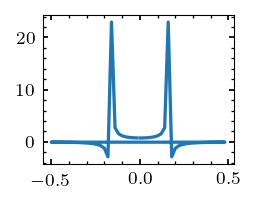

In [9]:
x = np.linspace(0, 50)
y = np.cos(x)
fft = np.fft.fft(y)
freq = np.fft.fftfreq(len(x), d=1)
plt.plot(freq, fft)

When the parameter $d$ of function `numpy.fft.fftfreq(len, d)` is set to 1, the distance between adjacent data point in $x$, the peak wavenumber is the same as expected. Thus, if we put the actual distance in certain unit between two adjacent points as $d$, say 8.33 um in this experiment, the resultant $k$ field will have unit um$^{-1}$.

**2D fftfreq function**

In [11]:
help(compute_wavenumber_field)

Help on function compute_wavenumber_field in module corrLib:

compute_wavenumber_field(shape, d)
    Compute the wave number field Kx and Ky, and magnitude field k. 
    Note that this function works for even higher dimensional shape.
    
    Args:
    shape -- shape of the velocity field and velocity fft field, tuple
    d -- sample spacing. This is the distance between adjacent samples, for example, velocities in PIV. 
        The resulting frequency space has the unit which is inverse of the unit of d. The preferred unit of d is um.
    
    Returns:
    k -- wavenumber magnitude field
    K -- wavenumber fields in given dimensions
    
    Test:
    shape = (5, 5)
    k, K = compute_wavenumber_field(shape, 0.2)



## 2 Compute energy spectrum

### 2.1 Generate perfect velocity correlation

The velocity correlation function should contain the minimum possible amount of noise, so that we can assume the noise from real space is negligible, and only consider the difference in FFT methods. Here, we use data from 08032020 (number 10, 7, 1, corresponding to volume fractions 1.6%, 3.2% and 6.4%, assuming single bacterium volume is 1 um$^3$). Each data is averaged over frame 3000-3400 to minimize the influence of random noise.

In [82]:
plt.figure(dpi=300)
numList = [10, 7, 1]
labelList = [r'1.6%', r'3.2%', r'6.4%']
vcorr_2d = {}
for num, label in zip(numList, labelList):
    temp = []
    for n in range(3000, 3400, 2):
        pivDir = r'D:\density_fluctuations\08032020\piv_imseq\{0:02d}\{1:04d}-{2:04d}.csv'.format(num, n, n+1)
        X, Y, U, V = read_piv(pivDir)
        CV = spatial_correlation(U, U) + spatial_correlation(V, V) # 2D correlation
        temp.append(CV)
    vcorr_2d[label] = np.stack(temp, axis=0).mean(axis=0)    

<Figure size 471x375 with 0 Axes>

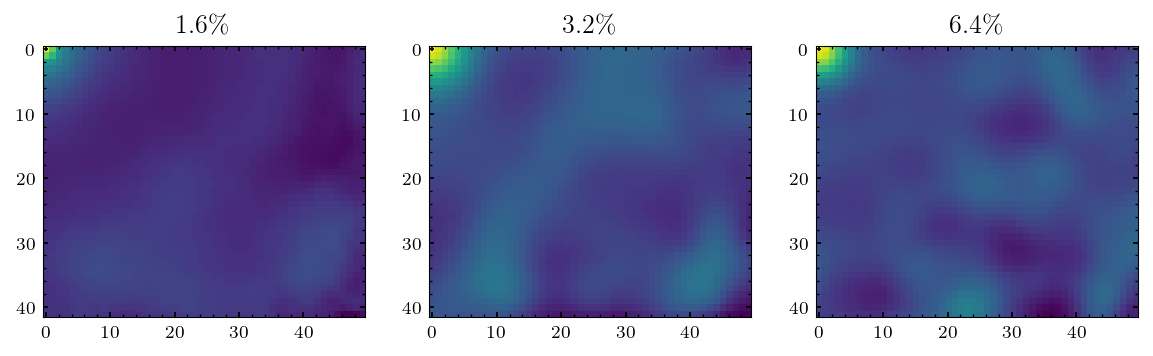

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
for num, kw in enumerate(vcorr_2d):
    ax[num].imshow(vcorr_2d[kw])
    ax[num].set_title(kw)

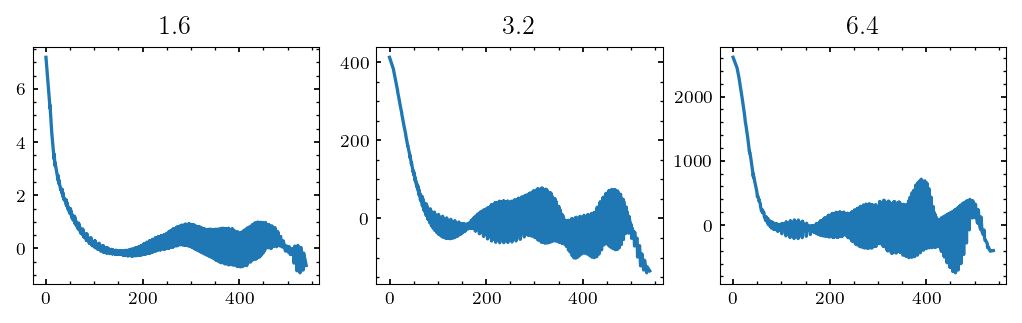

In [172]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 2))
for num, kw in enumerate(vcorr_2d):
    corr = vcorr_2d[kw]
    x = np.linspace(0, corr.shape[1]*25*0.33, corr.shape[1])
    y = np.linspace(0, corr.shape[0]*25*0.33, corr.shape[0])
    X, Y = np.meshgrid(x, y)
    dc = distance_corr(X, Y, corr)
    ax[num].plot(dc.R, dc.C)
    ax[num].set_title(kw)

In [94]:
# Save the averaged spatial velocity correlation
folder = r'I:\Google Drive\Research projects\DF\data\velocity_correlation'
for kw in vcorr_2d:
    name = kw.replace('\\%', '') + r'%'
    np.save(os.path.join(folder, '{}.npy'.format(name)), vcorr_2d[kw])

In [97]:
# To load vcorr_2d from data
# folder = r'I:\Google Drive\Research projects\DF\data\velocity_correlation'
# files = next(os.walk(folder))[2]
# vcorr_2d = {}
# for f in files:
#     kw = f.replace('.npy', '')
#     vcorr_2d[kw] = np.load(os.path.join(folder, f))

### 2.1 Two methods

We compare two methods:

**FFTreal: real part of standard fft**

Energy spectrum function $E(k)$ is defined as
$$
E(k) = \oint \frac{1}{2} \Phi_{ii}(k)d S(k)
$$

where $\Phi_{ii}(k)$ is the diagonal term of velocity spectrum tensor, defined as

$$
\Phi_{ij}(k) = \iiint\limits_{-\infty}^{\infty} R_{ij}(r)e^{-ik\cdot r} dr
$$

here $r$ is position vector (x, y, z) and $R_{ij}$ is spatial velocity correlation of $u_i$, $u_j$ and $u_k$.

It is not feasible to measure the full 3 dimensional flow simultaneous, so take a step back and measure $R_{11}(x, y)$, and thus $\Phi_{11}(k_x, k_y)$.

One dimensional spectra $E_{ij}(k_1)$ are defined to be twice the one dimensional Fourier transform of $R_{ij}(e_1r_1)$:
$$
E_{ij}(k_1) \equiv \frac{1}{\pi}\int^\infty_{-\infty} R_{ij}(e_1r_1)e^{-ik_1r_1}d r_1
$$

Since the flow in the textbook is measured by hot wire, which is naturally 1D, whereas PIV is naturally 2D, I adapt the equation above to a 2D velocity correlation function version:
$$
E_{11}(k_x, k_y) \equiv \frac{1}{\pi}\int^\infty_{-\infty} R_{11}(x, y)e^{-ik\cdot r}d^2r
$$

**velFT: Yi's method**

$$
E(k_x, k_y) = \langle u_k(k_x, k_y)u^*_k(k_x, k_y)+v_k(k_x, k_y)v_k^*(k_x, k_y)\rangle/2
$$

The angle bracket $\langle\rangle$ denotes an average over consecutive frames. 

The formula above needs to be revised due to an inconsistency of units. The kinetic energy density $E(k_x, k_y)$ is expected to have unit $\mu$m$^4$/s$^2$, so that integrating it over two dimensions of wavenumbers will result in unit of kinetic energy  $\mu$m$^2$/s$^2$. However, in the current formula, $u_k(k_x, k_y)$ has unit $\mu$m$^3$/s, which leads to $E(k_x, k_y)$ unit to be $\mu$m$^6$/s$^2$, differerent from my expectation.

Xiang showed me that the formula Yi gave can be derived from the definition. I attach his hand-written derivation here and type it in for documentation purpose.

<img src='temp_data\energy_spectrum_derivation_1.jpg' width='600px'>
<img src='temp_data\energy_spectrum_derivation_2.jpg' width='600px'>

The idea is to derive the energy spectrum definition in Yi's formula to the velocity correlation definition.
$$
E(k_x, k_y) = u_k(k_x, k_y)u_k^*(k_x, k_y)\\
= \iint u(x, y)e^{-ik_xx}e^{-k_yy}dxdy\left[\iint u(x', y')e^{-ik_xx'}e^{-ik_yy'}dx'dy'\right]^*\\
= \iint u(x, y)e^{-ik_xx}e^{-k_yy}dxdy\iint u^*(x', y')e^{ik_xx'}e^{ik_yy'}dx'dy'\\
= \iiiint u(x, y)u(x', y')e^{-ik_x(x-x')}e^{-k_y(y-y')}dxdydx'dy'\\
$$

here, we change variable and let $x'' = x - x'$ and $y'' = y - y'$ the original expression can be rearranged into
$$
\iiiint u(x'+x'', y'+y'')u(x', y')e^{-ik_xx''}e^{-k_yy''}d(x'+x'')d(y'+y'')dx'dy'\\
= \iint \left[\iint u(x'+x'', y'+y'')u(x', y')dx'dy'\right] e^{-ik_xx''}e^{-k_yy''} d(x'+x'')d(y'+y'')
$$

using the definition of velocity correlation function (average all possible pairs over available space):
$$
\langle u(x, y)u(x+x'', y+y'') \rangle = \frac{\iint u(x'+x'', y'+y'')u(x', y')dx'dy'}{\iint dx'dy'}
$$
we obtain
$$
\iint dx'dy'\iint \langle u(x, y)u(x+x'', y+y'') \rangle e^{-ik_xx''}e^{-k_yy''} dx''dy''\\
$$

the first integration is the available space size of velocity field, in this case the size of field of view $A$. In the code, $A$ should be step size $s$ times the row number $r$ and column number $c$ of velocity matrix size:
$$
A = rcss
$$
Note that $r$ and $s$ should have no unit and $s$ should have unit um. 

Let's draw a comparison between the two methods. Method I:
$$
E_1(k_x, k_y) = \iint \langle u(x, y)u(x+x'', y+y'') \rangle e^{-ik_xx''}e^{-k_yy''} dx''dy''
$$
Method II:
$$
E_2(k_x, k_y) = \iint dx'dy' \iint \langle u(x, y)u(x+x'', y+y'') \rangle e^{-ik_xx''}e^{-k_yy''} dx''dy''\\
= A  \iint \langle u(x, y)u(x+x'', y+y'') \rangle e^{-ik_xx''}e^{-k_yy''} dx''dy''
$$

Thus
$$
E_1(k_x, k_y) = \frac{E_2(k_x, k_y)}{A}
$$

### 2.2 Compare energy spectra at different concentrations using two methods

#### 2.2.1 FFTreal

In [99]:
# Load data
folder = r'I:\Google Drive\Research projects\DF\data\velocity_correlation'
files = next(os.walk(folder))[2]
vcorr_2d = {}
for f in files:
    kw = f.replace('.npy', '')
    vcorr_2d[kw] = np.load(os.path.join(folder, f))

In [17]:
def energy_spectrum_FFTreal(CV, d=25*0.33):
    """
    Compute energy spectrum using method 2
    
    Args:
    CV -- spatial velocity correlation, a 2D numpy array
    d -- actual distance between adjacent velocity (PIV step)
    
    Returns:
    k -- wavenumber flattened
    E -- energy density flattened
    """
    
    E = 1 / np.pi * np.fft.fft2(CV).real
    k, K = corrLib.compute_wavenumber_field(E.shape, d)

    ind = np.argsort(k.flatten())
    k_plot = k.flatten()[ind]
    E_plot = E.flatten()[ind]
    
    return k_plot, E_plot

In [106]:
kE_FFTreal = {} # save k, E data as dict of two-column np arrays (k, E)
for kw in vcorr_2d:
    k, E = energy_spectrum_FFTreal(vcorr_2d[kw], d=25*0.33)
    kE_FFTreal[kw] = np.stack([k, E], axis=1)

Text(0.5, 1.0, 'FFTreal')

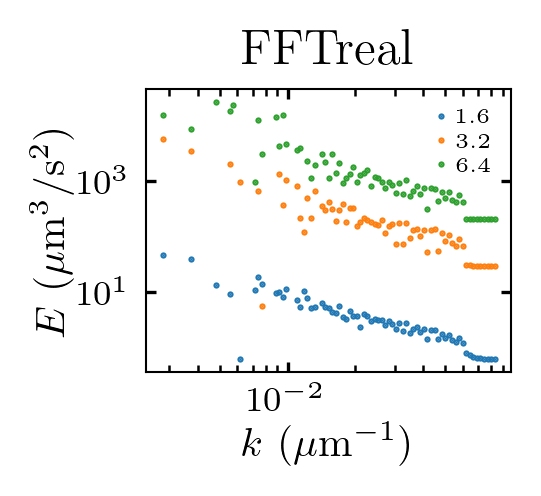

In [171]:
# plot
plt.figure(dpi=300)
for kw in kE_FFTreal:
    x, y = log_bin(kE_FFTreal[kw][:, 0], kE_FFTreal[kw][:, 1])
    plt.plot(x, y, label=kw, ls='', marker='o', markersize=0.5)
plt.legend(fontsize=5)
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.loglog()
plt.title('FFTreal')

#### 2.2.2 velFT

In [126]:
numList = [10, 7, 1]
labelList = [r'1.6%', r'3.2%', r'6.4%']
kE_velFT = {} # dict of dataframe with two columns (k, E)
for num, label in zip(numList, labelList):
    for count, n in enumerate(range(3000, 3400, 2)):
        pivDir = r'D:\density_fluctuations\08032020\piv_imseq\{0:02d}\{1:04d}-{2:04d}.csv'.format(num, n, n+1)
        pivData = pd.read_csv(pivDir)
        if count == 0:
            es_temp = energy_spectrum(pivData, 25*0.33)
        else:
            es_temp += energy_spectrum(pivData, 25*0.33)
    kE_velFT[label] = es_temp / (count + 1) / 2

In [131]:
# Save kE_velFT data
folder = r'I:\Google Drive\Research projects\DF\data\velFT'
for kw in kE_velFT:
    kE_velFT[kw].to_csv(os.path.join(folder, '{}.csv'.format(kw)), index=False)

In [132]:
# load kE_velFT data
folder = r'I:\Google Drive\Research projects\DF\data\velFT'
files = next(os.walk(folder))[2]
kE_velFT = {}
for f in files:
    kw = f.replace('.csv', '')
    kE_velFT[kw] = pd.read_csv(os.path.join(folder, f))

Text(0.5, 1.0, 'velFT')

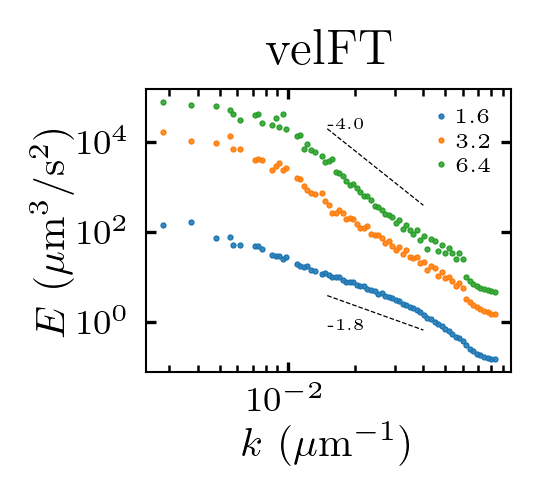

In [170]:
# plot kE_velFT
plt.figure(dpi=300)
for kw in kE_velFT:
    x, y = log_bin(kE_velFT[kw]['k'], kE_velFT[kw]['E'])
    plt.plot(x, y, label=kw, ls='', marker='o', markersize=0.5)
plt.legend(fontsize=5)
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.loglog()

# slope guide eye
s = -1.8
x = np.array([0.015, 0.04])
y = x ** s * 2e-3
plt.plot(x, y, ls='--', lw=0.3, color='black')
plt.text(x[0], y[1], '{:.1f}'.format(s), {'fontsize': 4})

s = -4
x = np.array([0.015, 0.04])
y = x ** s * 1e-3
plt.plot(x, y, ls='--', lw=0.3, color='black')
plt.text(x[0], y[0], '{:.1f}'.format(s), {'fontsize': 4})

plt.title('velFT')

### 2.3 Compare the two methods at a fixed concentration

Clearly, the two methods presented above give different energy spectrum result. Below, I apply both methods on each concentration: 1.6%, 3.2% and 6.4%, and compare results.

#### 2.3.1 $\phi=1.6 \%$

In [136]:
kw = r'1.6%'
folder_vcorr = r'I:\Google Drive\Research projects\DF\data\velocity_correlation'
folder_velFT = r'I:\Google Drive\Research projects\DF\data\velFT'
vcorr = np.load(os.path.join(folder_vcorr, '{}.npy'.format(kw)))
velFT = pd.read_csv(os.path.join(folder_velFT, '{}.csv'.format(kw)))

[]

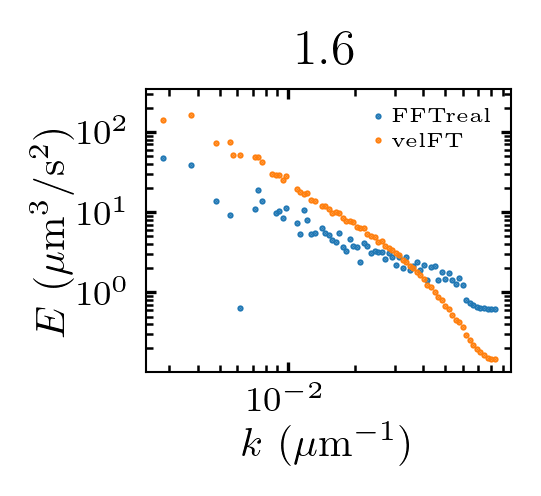

In [145]:
#plot
plt.figure(dpi=300)
k, E = energy_spectrum_FFTreal(vcorr, d=25*0.33)
x, y = log_bin(k, E)
plt.plot(x, y, label='FFTreal', ls='', marker='o', markersize=0.5)
x, y = log_bin(velFT.k, velFT.E)
plt.plot(x, y, label='velFT', ls='', marker='o', markersize=0.5)
plt.title(kw)
plt.legend(fontsize=5)
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.loglog()

#### 2.3.1 $\phi=3.2 \%$

In [146]:
kw = r'3.2%'
folder_vcorr = r'I:\Google Drive\Research projects\DF\data\velocity_correlation'
folder_velFT = r'I:\Google Drive\Research projects\DF\data\velFT'
vcorr = np.load(os.path.join(folder_vcorr, '{}.npy'.format(kw)))
velFT = pd.read_csv(os.path.join(folder_velFT, '{}.csv'.format(kw)))

[]

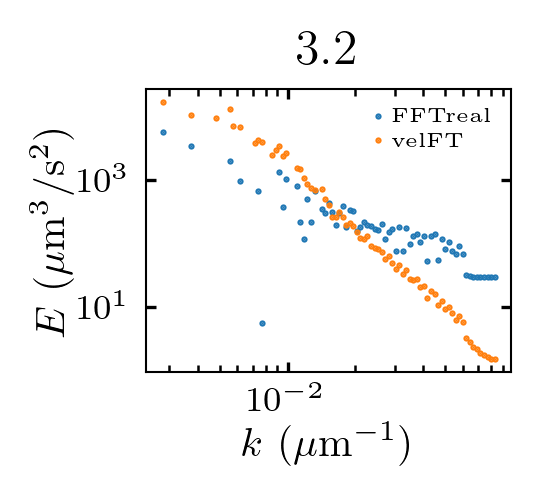

In [147]:
#plot
plt.figure(dpi=300)
k, E = energy_spectrum_FFTreal(vcorr, d=25*0.33)
x, y = log_bin(k, E)
plt.plot(x, y, label='FFTreal', ls='', marker='o', markersize=0.5)
x, y = log_bin(velFT.k, velFT.E)
plt.plot(x, y, label='velFT', ls='', marker='o', markersize=0.5)
plt.title(kw)
plt.legend(fontsize=5)
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.loglog()

#### 2.3.1 $\phi=6.4 \%$

In [15]:
kw = r'6.4%'
folder_vcorr = r'E:\Google Drive\Research projects\DF\data\velocity_correlation'
folder_velFT = r'E:\Google Drive\Research projects\DF\data\velFT'
vcorr = np.load(os.path.join(folder_vcorr, '{}.npy'.format(kw)))
velFT = pd.read_csv(os.path.join(folder_velFT, '{}.csv'.format(kw)))

E:\Github\Python\Correlation\src\corr_utils.py:1230: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1230: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


[]

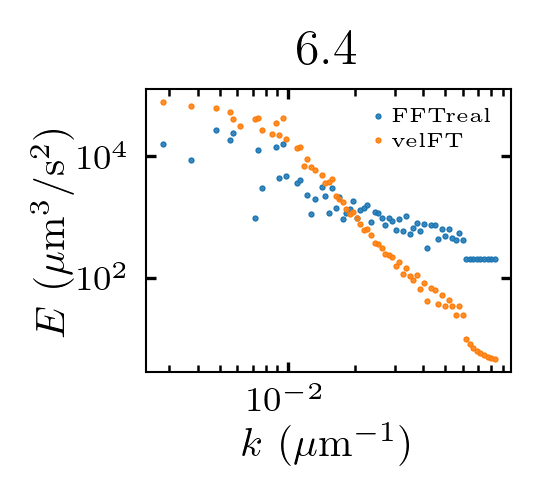

In [18]:
#plot
plt.figure(dpi=300)
k, E = energy_spectrum_FFTreal(vcorr, d=25*0.33)
x, y = log_bin(k, E)
plt.plot(x, y, label='FFTreal', ls='', marker='o', markersize=0.5)
x, y = log_bin(velFT.k, velFT.E)
plt.plot(x, y, label='velFT', ls='', marker='o', markersize=0.5)
plt.title(kw)
plt.legend(fontsize=5)
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.loglog()

## 3 Fit spectrum curve with formula
$$
E_k = 4\pi n \kappa^2 \left[ \frac{1}{3} + \frac{\cos(kl)}{(kl)^2} - \frac{\sin(kl)}{(kl)^3} \right] \frac{\epsilon^4k^2}{l^2} K_2^2(k\epsilon)
$$
- $\kappa$ is stresslet strength, $\epsilon$ is a factor describing the distance over which the regularisation acts and $K_2$ is the modified Bessel function of the second kind, $l$ is the dipolar length
- $\kappa \approx 11.2$ for _E. coli_, it is dimensionless
- I don't have an estimate for $\epsilon$, so try to range it from small to large (compare to 1)
- $K_2$ can be computed using `scipy.special.kn`, use `K2 = kn(2, x)`, [reference](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kn.html#scipy.special.kn)
- $l \approx 1.9$ um 
- Estimate the length scale in the simulation:
    - $\phi = (4\pi/3)a^3n$, $a = 0.3$
    - typical _E. coli_ is $1\times1\times1$ um$^3$, so 1 um corresponds to 0.3 in the simulation unit
    - the wavenumber unit is thus 1/(3.33um) = 0.3 um$^{-1}$

**construct the function to be fitted**

In [88]:
def E_k(k, n, ep = 1):
    """
    Energy spectrum in active turbulence | Boltzmann Lattice simulation | reference Bardfalvy 2019
    https://pubs.rsc.org/en/content/articlelanding/2019/sm/c9sm00774a#!divAbstract
    
    k -- wavenumber (um^-1)
    ep -- a factor describing the distance over which the regularisation acts
    """
    
    kappa = 11.2
    K_2 = kn(4, k*ep)
    l = 1.9
    
    
    Ek = 4 * np.pi * n * kappa**2 * (1/3 + np.cos(k*l)/(k*l)**2 - np.sin(k*l)/(k*l)**3) * ep**4 * k**2 / l**2 * K_2
    
    return Ek

In [58]:
summary = pd.read_csv(os.path.join(r'D:\density_fluctuations\08042020\energy_spectrum_10\summary.csv')).set_index('k')
s = range(9, 12)
for count, num in enumerate(s):
    temp_data = summary.loc[summary['sample'].astype('int')==num]
    if count == 0:
        data = temp_data
    else:
        data += temp_data
data /= count + 1
x, y = xy_bin(data.index, data.E)
###########################################
# log_bin() bins data to a set of evenly distributed xo in logspace
# the data in each bin are averages of yo in that bin, these are the output of log_bin(), x and y given above
# However, we noticed that the 1D energy spectrum should actually be the sum of 2D energy spectrum in a ring with fixed width dk.
# This sum can also be written as mean*area(or circumference 2*pi*k, given constant width dk)
# Here, the circumference is 2*pi*k, where k is x in the code
# so the following line reflect this modification
y *= 2*np.pi*x 
######################################
# data_list.append(np.stack([x, y], axis=1))    
# ax.plot(x, y, label=str(c), ls='', marker='o', markersize=2, mec=wowcolor(count1),
#        mew=0.5, mfc=(0,0,0,0))

I:\Github\Python\Correlation\src\corr_utils.py:1239: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


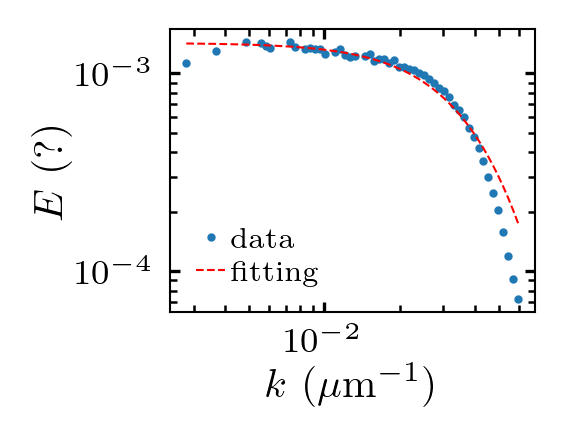

In [89]:
xx = x[(np.isnan(y)==False)&(x!=0)]
yy = y[(np.isnan(y)==False)&(x!=0)]
popt, pcov = curve_fit(E_k, xx[xx<6e-2], yy[xx<6e-2])
plt.figure(dpi=300)
plt.plot(xx[xx<6e-2], yy[xx<6e-2], ls='', marker='o', markersize=1, label='data')
n = 0.05
ep = 1
# xtest = np.logspace(-1.5, 0.5)
# plt.plot(xtest, E_k(xtest, n))
plt.plot(xx[xx<6e-2], E_k(xx[xx<6e-2], *popt), ls='--', color='red', lw=0.5, label='fitting')
plt.loglog()
plt.legend(fontsize=5)
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ (?)')
plt.legend(loc='lower left', fontsize=7)

In [90]:
popt

array([5.65594611e-07, 9.80441576e+01])

## 4 Energy spectrum growth

[Simha and Ramaswamy (2002)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.89.058101) predicted a growth rate of hydrodynamic instability in SPP suspensions, with unit s$^{-1}$. I'm not very clear what this rate really is in experiment, but would like to first test the growth rate of energy spectrum at various modes.

In this section, I will investigate:

- evolution of kinetic energy spectra
- evolution of number fluctuations

I:\Github\Python\Correlation\src\corr_utils.py:1239: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


Text(0, 0.5, '$E$ ($\\mu$m$^3$/s$^2$)')

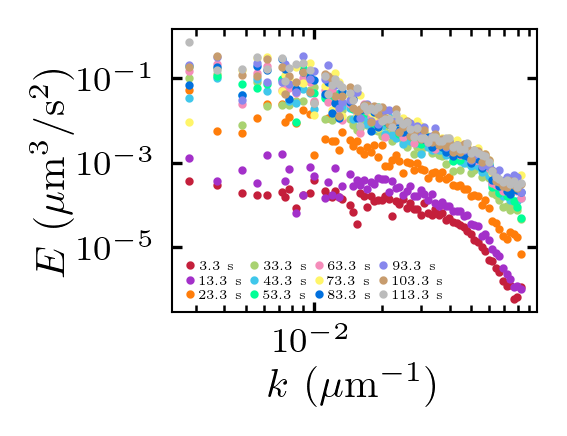

In [129]:
plt.figure(dpi=300)
piv_folder = r'E:\moreData\08032020\piv_imseq\04' 
l = readdata(piv_folder)
npiv = len(l)
count = 0 # color
longE = []
t = []
for i in range(50, npiv, 150):
    pivData = pd.read_csv(l.Dir[i])
    es = energy_spectrum(pivData, 25*0.33)
    x, y = xy_bin(es.k, es.E, mode='log')
    ###########################################
    # log_bin() bins data to a set of evenly distributed xo in logspace
    # the data in each bin are averages of yo in that bin, these are the output of log_bin(), x and y given above
    # However, we noticed that the 1D energy spectrum should actually be the sum of 2D energy spectrum in a ring with fixed width dk.
    # This sum can also be written as mean*area(or circumference 2*pi*k, given constant width dk)
    # Here, the circumference is 2*pi*k, where k is x in the code
    # so the following line reflect this modification
    y *= 2*np.pi*x 
    ######################################
    plt.plot(x, y, ls='', marker='o', label='{:.1f} s'.format(i*2/30), markersize=1, color=wowcolor(count))
    count += 1
    t.append(i*2/30)
    longE.append(y[4])
plt.legend(fontsize=3, ncol=4, loc='lower left')
plt.loglog()
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')

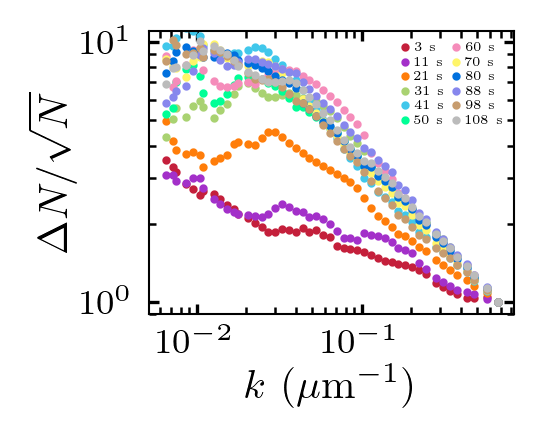

In [34]:
# growth of GNF
seg_length = 50
k_data = pd.read_csv(r'D:\density_fluctuations\08032020\df2_kinetics\01\kinetics_data.csv'.format(seg_length))
plot_data, fig, ax = plot_std(k_data, seg_length, tlim=[3, 300], lb=10, mpp=0.33, fps=30, num_curves=12)
# guide of the eye slope
# x = np.array([3, 15])
# y = x**0.5 * 1
# ax.plot(x, y, lw=0.5, ls='--', color='black')
# ax.text(0.6*x[0]+0.11*x[1], y.mean(), '0.5', {'fontsize': 8})
# # ax.axis([0.9, 110, 0.9, 11])
ax.legend(ncol=2, fontsize=3, loc='upper right')

In [33]:
def plot_std(k_data, seg_length, tlim=None, xlim=None, lb=10, mpp=0.33, fps=10, num_curves=5):
    """
    Args:
    k_data -- kinetics data computed by df2_kinetics.py, has 3 columns (n, d, segment)
    seg_length -- segment length [frame] used in computing kinetics
    tlim -- bounds of time, only plot the data in the bounds (second)
            tlim can be None, int or list of 2 int
                None - plot all t
                int - plot all below tlim
                list - plot between tlim[0] and tlim[1]
    xlim -- box size beyond which the data get cut off (pixel), can be either integer or a list of 2 integers
    lb -- size of single bacterium [px]
    mpp -- microns per pixel
    fps -- frames per second
    num_curve -- number of curves in the final plot
    
    Returns:
    plot_data -- a dict containing (x, y)'s of all the curved plotted
                example {'l1': (x1, y1), 'l2': (x2, y2)} 
                where x1, y1, x2, y2 are all array-like object
    fig -- the figure handle of the plot, use for saving the figure
    """
    
#     symbol_list = [ 'x', 's', 'P', '*', 'd', 'o', '^']
    
    plot_data = {}
    
    # filter out the data we don't need using tlim
    if tlim == None:
        data = k_data
    elif isinstance(tlim, int):
        data = k_data.loc[(k_data.segment-1) * seg_length < tlim * fps]
    elif isinstance(tlim, list) and len(tlim) == 2:
        data = k_data.loc[((k_data.segment-1) * seg_length < tlim[1] * fps) & ((k_data.segment-1) * seg_length >= tlim[0] * fps)]
    else:
        raise ValueError('tlim must be None, int or list of 2 int')
    
    
    # determine the number of curves we want
    num_total = len(data.segment.drop_duplicates())
    if num_total < num_curves:
        seg_list = data.segment.drop_duplicates()
    else:
        seg_list = np.floor(num_total / num_curves * (np.arange(num_curves))) +  data.segment.min()
    
    fig, ax = plt.subplots(dpi=300)
    for num, i in enumerate(seg_list):
        subdata = data.loc[data.segment==i]
        x, y = postprocess_gnf(subdata, lb, xlim=xlim, sparse=1)
        x, y = xy_bin(x, y)
        ax.plot(1/(x**0.5*3), y, mec=wowcolor(num), label='{:d} s'.format(int(seg_length*(i-1)/fps)),
               ls='', marker='o', markersize=1, mfc=(0,0,0,0), mew=1)
        plot_data['l'+str(num)] = (x, y)
        
    ax.set_ylim([0.9, 11])
    ax.legend(ncol=2, loc='upper left')
    ax.loglog()
    ax.set_xlabel('$k$ ($\mu$m$^{-1}$)')
    ax.set_ylabel('$\Delta N/\sqrt{N}$')
    
    return plot_data, fig, ax

## 5 Mapping energy spectra to GNF

GNF may correlate with energy spectra at every length scale. Here we plot for energy spectra as a function of their corresponding fluctuations $\Delta N/N$ at same length scale (wavenumber), at various concentrations. Would results from different concentrations collapse? Let's see:

### 5.0 Original GNF plot

This is a reference for the work in this section. The several concerns regarding the absolute values of fluctuations, since it depends on the illumination conditions which is not controlled during experiment. Let's use the rescaled fluctuations first. 

In [3]:
dirs = data_log_mapping(kw='aug')
date = []
num = []
conc = []
for kw in dirs:
    if int(kw) <= 120:
        conc.append(int(kw))
        d, n = dirs[kw][1].split('-')
        date.append(d)
        num.append(int(n))
data_log = pd.DataFrame().assign(conc=conc, date=date, num=num).sort_values(by='conc')

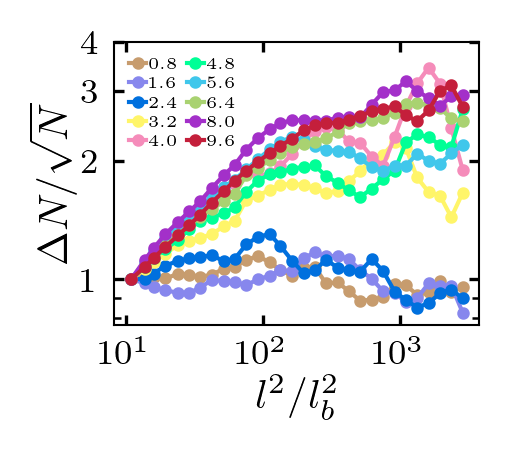

In [19]:
lb = 10
fig, ax = plt.subplots(dpi=300)
data_dir = r'E:\moreData\{0}\df2_kinetics\{1:02d}\kinetics_data.csv'
for num, i in data_log.iterrows():
    if i.conc != 0 and i.conc != 85:        
        k_data = pd.read_csv(data_dir.format(i.date, i.num))
        gnf_data = k_data.loc[k_data.segment==k_data.segment.max()]
        x, y = postprocess_gnf(gnf_data, lb, xlim=[10, 10000], sparse=1)
        ax.plot(x, y, marker='o', label='{:.1f}'.format(i.conc*0.08), color=wowcolor(num), markersize=2, lw=1)
ax.loglog()
ax.legend(loc='upper left', ncol=2, fontsize=4)
ax.set_xlabel('$l^2/l_b^2$')
ax.set_ylabel(' $\Delta N/\sqrt N$')
ax.set_yticks([1, 2, 3, 4])
ax.set_yticklabels(['1', '2', '3', '4'])
ax.set_xticks([10, 100, 1000])

### 5.1 Construct data

The data should be binned into same brackets.
- fluctuation data
- energy spectrum data

In fluctuation data, ($l^2/l_b^2$) ranges from 10.89 to 2883.69.

In energy data, $k$ ranges from 0.0024 to 0.15 um$^{-1}$, corresponding to 6.7 to 416.7 um, and corresponding to $l^2/l_b^2$ from 5 to 19293. 

In the following data construction, all the data will be converted to $l^2/l_b^2$ scale, within a common range (10, 2883). The range will be binned on a log scale.

#### Fluctuation data

In [ ]:
dirs = data_log_mapping(kw='aug')
date = []
num = []
conc = []
for kw in dirs:
    if int(kw) <= 120:
        conc.append(int(kw))
        d, n = dirs[kw][1].split('-')
        date.append(d)
        num.append(int(n))
data_log = pd.DataFrame().assign(conc=conc, date=date, num=num).sort_values(by='conc')

In [79]:
lb = 10
# fig, ax = plt.subplots(dpi=300)
data_dir = r'E:\moreData\{0}\df2_kinetics\{1:02d}\kinetics_data.csv'
set_range = np.array([10, 2883])
set_range_log = np.log10(set_range)
bins = np.logspace(set_range_log[0], set_range_log[1], 30)
l_ = np.array([])
df_ = np.array([])
for num, i in data_log.iterrows():
    if i.conc != 0 and i.conc != 85:        
        k_data = pd.read_csv(data_dir.format(i.date, i.num))
        gnf_data = k_data.loc[k_data.segment==k_data.segment.max()]
        x, y = postprocess_gnf(gnf_data, lb, xlim=[10, 10000], sparse=1)
        l, df = xy_bin(x, y, bins=bins)
        l_ = np.concatenate((l_, l))
        df_ = np.concatenate((df_, df))

In [81]:
df_data = pd.DataFrame(index=l_, data={'df':df_})

In [82]:
df_data

,df
10.000000,1.000000
12.156883,1.023520
14.778980,1.012741
17.966633,1.005943
21.841825,1.033020
...,...
1085.759148,2.606138
1319.944669,2.517681
1604.641261,2.681986
1950.743571,3.009425


In [80]:
bins

array([  10.        ,   12.15688278,   14.77897989,   17.96663261,
         21.84182465,   26.55285019,   32.27998872,   39.24240389,
         47.7065304 ,   57.99626979,   70.50538533,   85.71257047,
        104.19976718,  126.6744355 ,  153.99662633,  187.21189345,
        227.59130432,  276.68008079,  336.3567309 ,  408.90493491,
        497.10093609,  604.31978087,  734.66447363,  893.12298868,
       1085.75914794, 1319.94466863, 1604.64126096, 1950.74357097,
       2371.49609215, 2883.        ])

Given the xy_bin function a set of bins!

#### Energy spectrum data

In [40]:
conc = [120, 100, 85, 80, 70, 60, 50, 40, 30, 20, 10]
folders = ['08062020', '08062020', '08052020', '08032020', '08042020', '08032020', '08042020', '08032020', '08042020', '08032020', '08042020']
sample_num = [range(3, 6), range(0, 3), range(3, 6), range(0, 3), range(0, 3), range(3, 6), range(3, 6), range(6, 9), range(6, 9), range(9, 12), range(9, 12)]

In [75]:
data_list = []
set_range = np.array([10, 2883])
set_range_log = np.log10(set_range)
bins = np.logspace(set_range_log[0], set_range_log[1], 30)

l_ = np.array([])
E_ = np.array([])

count1 = -1
for c, f, s in zip(conc, folders, sample_num):
    count1 += 1
    if c != 85:
        summary = pd.read_csv(os.path.join(r'E:\moreData', f, r'energy_spectrum_10\summary.csv')).set_index('k')
        for count, num in enumerate(s):
            temp_data = summary.loc[summary['sample'].astype('int')==num]
            if count == 0:
                data = temp_data
            else:
                data += temp_data
        data /= count + 1
#         data.index = (1 / data.index / 3) ** 2
        x, y = xy_bin(data.index, data.E)
        ###########################################
        # log_bin() bins data to a set of evenly distributed xo in logspace
        # the data in each bin are averages of yo in that bin, these are the output of log_bin(), x and y given above
        # However, we noticed that the 1D energy spectrum should actually be the sum of 2D energy spectrum in a ring with fixed width dk.
        # This sum can also be written as mean*area(or circumference 2*pi*k, given constant width dk)
        # Here, the circumference is 2*pi*k, where k is x in the code
        # so the following line reflect this modification
        y *= 2*np.pi*x 
        ######################################
        
        data_list.append(np.stack([x, y], axis=1))
        
        l0 = (1 / x / 3) ** 2
        l, E = xy_bin(l0, y, bins=bins)
        
        l_ = np.concatenate((l_, l))
        E_ = np.concatenate((E_, E))
        
        
        ###########################################
        # Cut off the data x > 0.15
#         xx = x[x<0.15]
#         yy = y[x<0.15]
        ###########################################   

#         ax.plot(xx, yy, label=str(c), ls='', marker='o', markersize=2, mec=wowcolor(count1),
#                mew=0.5, mfc=(0,0,0,0))
    
# ax.legend(loc='upper right', ncol=2, fontsize=4)
# ax.loglog()

# # guide eye
# # x = np.array([0.02, 0.05])
# # y = x ** (-9/3) * 2e4
# # plt.plot(x, y, color='black', ls='--', lw=0.3)
# # plt.text(x[0], y[0], '-3', {'fontsize':3})

# ax.set_xlabel('$k$ ($\mu$m$^{-1}$)')
# ax.set_ylabel('$E$ ($\mu$m$^3$/s$^2$)')

E:\anaconda\miniconda\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


In [76]:
E_data = pd.DataFrame(index=l_, data={'E':E_})

In [93]:
df_data.iloc[0]

df    1.0
Name: 10.0, dtype: float64

#### Plot E and GNF together

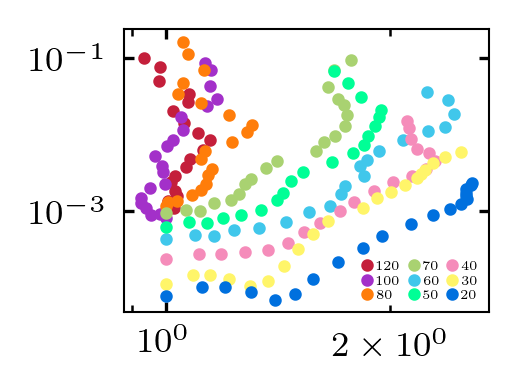

In [101]:
c = [120, 100, 80, 70, 60, 50, 40, 30, 20, 10]
plt.figure(dpi=300)
for i in range(0, 9):
    plt.plot(df_data.iloc[i*29: (i+1)*29], E_data.iloc[i*29: (i+1)*29], 
             ls='', marker='o', markersize=2, color=wowcolor(i), label='{:d}'.format(c[i]))
plt.loglog()
plt.legend(fontsize=3, ncol=3, loc='lower right')
plt.xlabel(' $\Delta N/\sqrt N$')
plt.ylabel()

In [69]:
l0

array([1.86049600e+04, 1.69815600e+04, 1.54998119e+04, 1.41473556e+04,
       1.29129097e+04, 1.17861769e+04, 1.07577587e+04, 9.81907647e+03,
       8.96230017e+03, 8.18028300e+03, 7.46650176e+03, 6.81500243e+03,
       6.22035052e+03, 5.67758574e+03, 5.18218060e+03, 4.73000269e+03,
       4.31728014e+03, 3.94057024e+03, 3.59673066e+03, 3.28289324e+03,
       2.99644012e+03, 2.73498183e+03, 2.49633743e+03, 2.27851626e+03,
       2.07970136e+03, 1.89823431e+03, 1.73260140e+03, 1.58142101e+03,
       1.44343206e+03, 1.31748352e+03, 1.20252478e+03, 1.09759691e+03,
       1.00182467e+03, 9.14409151e+02, 8.34621190e+02, 7.61795231e+02,
       6.95323797e+02, 6.34652413e+02, 5.79274991e+02, 5.28729597e+02,
       4.82594608e+02, 4.40485187e+02, 4.02050079e+02, 3.66968676e+02,
       3.34948346e+02, 3.05721992e+02, 2.79045822e+02, 2.54697315e+02,
       2.32473369e+02, 2.12188603e+02, 1.93673810e+02, 1.76774550e+02,
       1.61349856e+02, 1.47271064e+02, 1.34420736e+02, 1.22691680e+02,
      

## Appendix: How to bin energy spectrum data from 2D to 1D?

$E(k)$, according to the definition, should have the property $\int E(k)dk = E_{total}$. Similarly, $E(k_x, k_y)$ should satisfy $\iint E(k_x, k_y)dk_xdk_y = E_{total}$. Imagine an energy spectrum in 2D, $E(k_x, k_y)$, as shown below, what it really means is the area density of energy with a unit [E]/[k]$^2$. This is consistent with the definition 

When converting $E(k_x, k_y)$ to scalar variable $E(k)$, all the spots in the shell $\sqrt{k_x^2+k_y^2}-k \le dr$

(-0.5, 9.5, 9.5, -0.5)

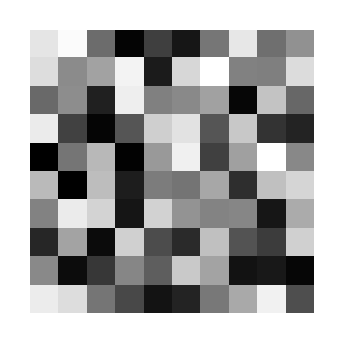

In [162]:
plt.figure(dpi=300)
a = np.random.rand(10, 10)
plt.imshow(a, cmap='gray')
plt.axis('off')

In [8]:
conc = [120, 100, 85, 80, 70, 60, 50, 40, 30, 20, 10]
folders = ['08062020', '08062020', '08052020', '08032020', '08042020', '08032020', '08042020', '08032020', '08042020', '08032020', '08042020']
sample_num = [range(3, 6), range(0, 3), range(3, 6), range(0, 3), range(0, 3), range(3, 6), range(3, 6), range(6, 9), range(6, 9), range(9, 12), range(9, 12)]

E:\Github\Python\Correlation\src\corr_utils.py:1242: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1242: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1242: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1242: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1242: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1242: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1242: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1

Text(0, 0.5, '$E$ ($\\mu$m$^3$/s$^2$)')

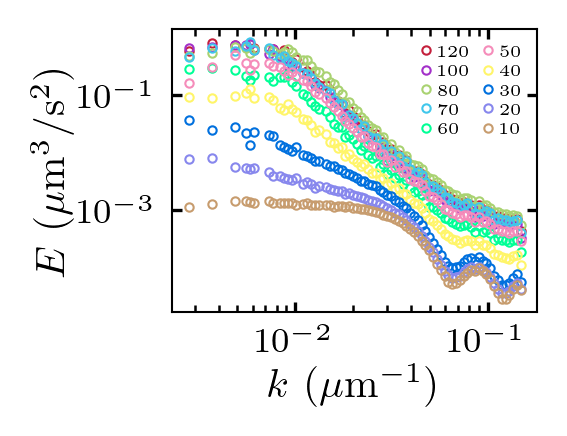

In [13]:
data_list = []
fig, ax = plt.subplots(dpi=300)
count1 = -1
for c, f, s in zip(conc, folders, sample_num):
    count1 += 1
    if c == 85:
        continue
    summary = pd.read_csv(os.path.join(r'E:\moreData', f, r'energy_spectrum_10\summary.csv')).set_index('k')
    for count, num in enumerate(s):
        temp_data = summary.loc[summary['sample'].astype('int')==num]
        if count == 0:
            data = temp_data
        else:
            data += temp_data
    data /= count + 1
    x, y = xy_bin(data.index, data.E)
    ###########################################
    # log_bin() bins data to a set of evenly distributed xo in logspace
    # the data in each bin are averages of yo in that bin, these are the output of log_bin(), x and y given above
    # However, we noticed that the 1D energy spectrum should actually be the sum of 2D energy spectrum in a ring with fixed width dk.
    # This sum can also be written as mean*area(or circumference 2*pi*k, given constant width dk)
    # Here, the circumference is 2*pi*k, where k is x in the code
    # so the following line reflect this modification
    y *= 2*np.pi*x 
    ######################################
    
    data_list.append(np.stack([x, y], axis=1))
    
    ###########################################
    # Cut off the data x > 0.15
    xx = x[x<0.15]
    yy = y[x<0.15]
    ###########################################   
    
    ax.plot(xx, yy, label=str(c), ls='', marker='o', markersize=2, mec=wowcolor(count1),
           mew=0.5, mfc=(0,0,0,0))
    
ax.legend(loc='upper right', ncol=2, fontsize=4)
ax.loglog()

# guide eye
# x = np.array([0.02, 0.05])
# y = x ** (-9/3) * 2e4
# plt.plot(x, y, color='black', ls='--', lw=0.3)
# plt.text(x[0], y[0], '-3', {'fontsize':3})

ax.set_xlabel('$k$ ($\mu$m$^{-1}$)')
ax.set_ylabel('$E$ ($\mu$m$^3$/s$^2$)')

In [14]:
xx

array([0.00244379, 0.00255794, 0.00267741, 0.00280247, 0.00293337,
       0.00307038, 0.00321379, 0.0033639 , 0.00352102, 0.00368548,
       0.00385763, 0.00403781, 0.00422641, 0.00442381, 0.00463044,
       0.00484672, 0.0050731 , 0.00531006, 0.00555808, 0.00581769,
       0.00608942, 0.00637385, 0.00667156, 0.00698317, 0.00730934,
       0.00765075, 0.0080081 , 0.00838214, 0.00877366, 0.00918346,
       0.0096124 , 0.01006137, 0.01053132, 0.01102322, 0.01153809,
       0.01207702, 0.01264111, 0.01323155, 0.01384957, 0.01449646,
       0.01517356, 0.01588229, 0.01662412, 0.0174006 , 0.01821335,
       0.01906406, 0.01995451, 0.02088654, 0.02186211, 0.02288325,
       0.02395208, 0.02507084, 0.02624185, 0.02746756, 0.02875051,
       0.0300934 , 0.031499  , 0.03297026, 0.03451024, 0.03612214,
       0.03780934, 0.03957534, 0.04142383, 0.04335866, 0.04538386,
       0.04750365, 0.04972245, 0.05204489, 0.05447581, 0.05702027,
       0.05968358, 0.06247129, 0.0653892 , 0.0684434 , 0.07164

[]

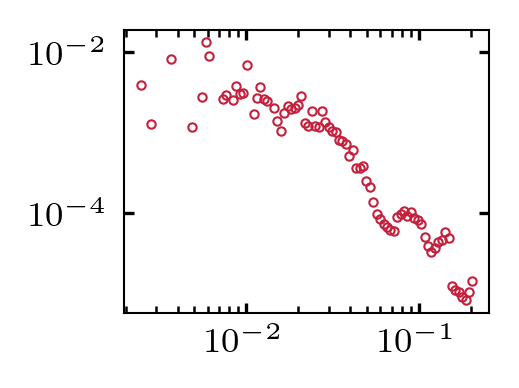

In [49]:
# test 1 curve at low concentration
folder = r'D:\density_fluctuations\08032020\energy_spectrum_10\09'
data = pd.read_csv(os.path.join(folder, '3000-3001.csv'))

plt.figure(dpi=300)
x, y = xy_bin(data.k, data.E)
###########################################
# log_bin() bins data to a set of evenly distributed xo in logspace
# the data in each bin are averages of yo in that bin, these are the output of log_bin(), x and y given above
# However, we noticed that the 1D energy spectrum should actually be the sum of 2D energy spectrum in a ring with fixed width dk.
# This sum can also be written as mean*area(or circumference 2*pi*k, given constant width dk)
# Here, the circumference is 2*pi*k, where k is x in the code
# so the following line reflect this modification
y *= 2*np.pi*x 
######################################
   
plt.plot(x, y, ls='', marker='o', markersize=2, mec=wowcolor(0),
       mew=0.5, mfc=(0,0,0,0))
plt.loglog()

In [40]:
y

array([3.85875681e-01,            nan,            nan, 3.42098926e-01,
                  nan,            nan,            nan,            nan,
                  nan, 3.60128308e-01,            nan,            nan,
                  nan,            nan,            nan, 8.04656602e-01,
                  nan,            nan, 7.90317305e-01, 1.60162494e-01,
       5.02147891e-01,            nan,            nan,            nan,
       2.08709345e-01, 4.09533656e-01,            nan, 1.57474770e+00,
       3.58653473e-01, 6.77527377e-01, 1.92192706e-01, 7.58586218e-01,
                  nan, 4.22590454e-01, 2.47227150e-01, 2.96713893e-01,
       3.14710321e-01, 2.52863006e-01,            nan, 1.94708771e-01,
       1.25313571e-01, 1.68569879e-01, 1.93284565e-01, 6.55783901e-02,
       4.11154658e-02, 5.51123993e-02, 6.41575710e-02, 4.50637040e-02,
       4.30861567e-02, 1.90500371e-02, 2.37988712e-02, 2.35219478e-02,
       2.30117678e-02, 1.17741187e-02, 2.04907382e-02, 1.02387371e-02,
      